In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video
import deeptime as dt
import tqdm
import multiprocessing
import os
import shutil
import pickle
import json
from scipy.spatial import ConvexHull
from pprint import pprint
from toy_potentials.potentials import load_potential
from toy_potentials.binning import load_binning
from toy_potentials.experiment_utils import initialize_walkers, move_walkers_iteration, simple_we_resample, skip_resampling

### Load System Parameters

In [10]:
param_file = './fpvt_muller_brown_potential.json'
with open(param_file, 'r') as file:
    params = json.load(file)
    print("Loaded parameters:")
    pprint(params)

# Visualization params
n_contours = 100
potential_cmap = 'nipy_spectral'
experiment_name = params['experiment_name']
output_folder = os.path.join(os.path.dirname(param_file), experiment_name)
frames_dir = os.path.join(output_folder,'frames')
movie_filename = os.path.join(output_folder,f'{experiment_name}_trajectories.mp4')

Loaded parameters:
{'binning_strategy': 'FPVT',
 'experiment_name': 'Muller_Brown_Potential_FPVT',
 'gamma': 1,
 'integration_step': 0.0001,
 'kT': 0.25,
 'min_weight': 1e-20,
 'n_bins': 64,
 'n_iters': 100,
 'n_processes': 8,
 'n_steps_per_iter': 50,
 'n_walkers': 1024,
 'n_walkers_per_bin': 16,
 'potential_type': 'muller_brown',
 'scale_distances': False,
 'steady_state': False,
 'use_resampling': True}


### Initializing System

In [5]:
# Load the potential and associated parameters
(potential, 
 forces, 
 reached_tstate,
 tstate_location,
 x_range, 
 y_range, 
 basis_location, 
 basis_scale, 
 E_max,
 saddle_points) = load_potential(params['potential_type'])
params['start_state'] = basis_location
params['end_state'] = tstate_location
E_max = E_max / params['kT']

# Load the sampling algorithm
if params['use_resampling']:
    print("Using resampling")
    # Function for resampling walkers
    resample_walkers = simple_we_resample
else:
    print("Skipping resampling")
    resample_walkers = skip_resampling
    binning = None

# Delete previous binning history file if it exists
if params['binning_strategy'].lower() == 'cvt':
    bin_history_data_path = os.path.join(output_folder, params['bin_history_filename'])
    if os.path.exists(bin_history_data_path):
        os.remove(bin_history_data_path)
    params['bin_data_path'] = bin_history_data_path

# Ensure output folder exists for saving binning history
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load binning scheme
print(f"Loading binning scheme: {params['binning_strategy']}")
binning = load_binning(**params)

# Initialize model dynamic system with given potential
sigma = np.sqrt(2*params['kT']*params['gamma'])
model = dt.data.custom_sde(
    dim = 2, 
    rhs = forces,
    sigma = np.diag([sigma, sigma]), 
    h = params['integration_step'], 
    n_steps = 1)

# Initialize walkers with uniform weights
walkers = initialize_walkers(params['n_walkers'], 
                            x_loc=basis_location[0], 
                            y_loc=basis_location[1], 
                            x_scale=basis_scale[0], 
                            y_scale=basis_scale[1])
iter_final_coords = walkers[:, :2]
iter_init_coords = iter_final_coords
iter_weights = walkers[:, 2]

Using resampling
Loading binning scheme: FPVT


### Visualizing the initial conditions

<Figure size 1000x1000 with 0 Axes>

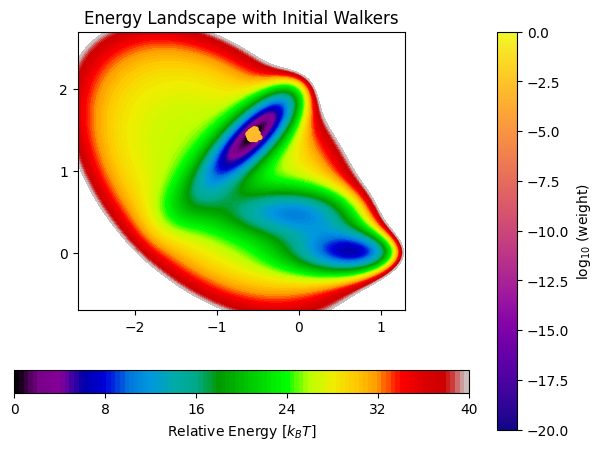

In [6]:
# Create a 2D grid for plotting the energy landscape
x = np.linspace(x_range[0], x_range[1], 300)
y = np.linspace(y_range[0], y_range[1], 300)
X, Y = np.meshgrid(x, y)
xy =  np.dstack([X, Y]).reshape(-1, 2)
E_landscape = potential(xy).reshape(X.shape)
E_min = np.min(E_landscape)
E_landscape = (E_landscape - E_min) / params['kT']

# Assign bin IDs and compute the alpha shape
iter_bin_ids = binning(iter_init_coords, iter_final_coords, iter_weights)[0:2]

# Plot the energy landscape and initial walkers
plt.figure(figsize=(10, 10))
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, E_landscape, levels=np.linspace(0, E_max, n_contours), cmap=potential_cmap, zorder=0)

iter_final_coords_u = np.unique(iter_final_coords, return_index=False, axis=0)

scatter = ax.scatter(iter_final_coords[:, 0], iter_final_coords[:, 1], 
    c=np.log10(iter_weights), 
    s=8,
    cmap='plasma',
    vmin=int(np.log10(params['min_weight'])), 
    vmax=0,
    zorder=2
)

if params['use_resampling']:
    cbar_scatter = fig.colorbar(scatter, ax=ax, orientation='vertical')
    cbar_scatter.set_label('log$_{10}$ (weight)')

cbar_contour = fig.colorbar(contour, ax=ax, orientation='horizontal')
cbar_contour.set_label('Relative Energy [$k_{B}T$]')
cbar_contour.set_ticks(np.linspace(0, E_max, 6))

# Create a dense grid of sample points
if params['steady_state']:
    # Determine which points are within the target state
    target_state = reached_tstate(xy)
    tstate_points = xy[target_state]
    hull = ConvexHull(tstate_points)
    # Plot only the points within the target state
    for simplex in hull.simplices:
        plt.plot(tstate_points[simplex, 0], tstate_points[simplex, 1], 'r-')  # 'r-' means red line

plt.title('Energy Landscape with Initial Walkers')

# Update the font size
plt.rcParams.update({'font.size': 16})

# Set to 1:1 aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

### Evolve the ensemble!

In [7]:
# Running dynamics now
# Store the state of walkers at each step
n_iters = params['n_iters']
trajs = [None] * n_iters
weights = [None] * n_iters
bin_ids = [None] * n_iters
if params['steady_state']:
    recycled_weight = np.zeros(n_iters) # tracks the total weight recycled at the end of each iteration

for i in tqdm.tqdm(range(n_iters), total=n_iters):
    n_walkers = iter_final_coords.shape[0]

    # Assign walker bins
    if params['use_resampling']:
        iter_bin_ids = binning(iter_init_coords, iter_final_coords, iter_weights)

    # Resample walkers to ensure each bin has exactly n_walkers_per_bin
    iter_final_coords, iter_weights, bin_ids[i] = resample_walkers(
        iter_final_coords, 
        iter_weights, 
        iter_bin_ids, 
        params['n_walkers_per_bin'],
        params['min_weight'])

    # Run the walkers for this iteration
    trajs[i] = move_walkers_iteration(model, 
        iter_final_coords, 
        n_steps_iter=params['n_steps_per_iter'], 
        n_threads=params['n_workers'])

    # Recycle any walkers that have reached the target state back to the basis
    if params['steady_state']:
        reached_target = reached_tstate(trajs[i][:,-1,:])
        n_recycled = reached_target.sum()
        if n_recycled > 0:
            # Recycle the walkers back to the basis
            recycled_walkers = initialize_walkers(n_recycled, 
                                        x_loc=basis_location[0], 
                                        y_loc=basis_location[1], 
                                        x_scale=basis_scale[0], 
                                        y_scale=basis_scale[1])
            recycled_weight[i] = iter_weights[reached_target].sum()
            trajs[i][reached_target,-1,:] = recycled_walkers[:, :2]

    # Update initial/final walker positions for this iter
    iter_init_coords = trajs[i][:,0,:]
    iter_final_coords = trajs[i][:,-1,:]

    # Update weights for this iter from initial iter weights
    weights[i] = iter_weights

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


### Define the movie frame update function

In [11]:
def update_plot(idx_it, idx_ts, scatter, title_text, trajs, weights):
    # update scatter plots
    scatter.set_offsets(trajs[idx_it][:,idx_ts,:])              # Sets the positions
    scatter.set_array(np.log10(weights[idx_it]))                # Sets the colors
    # update title text 
    title_text.set_text(f"Iteration {idx_it:g}, Timestep {idx_ts:g}")

# Function to generate frames in parallel
def generate_frames(progress_queue, start_frame, end_frame, trajs, weights, bin_ids):
    plt.rcParams.update({'font.size': 18})
    # Plot the energy landscape and initialize scatter plot
    plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots()
    # Energy landscape
    contour = ax.contourf(X, Y, E_landscape, levels=np.linspace(0, E_max, n_contours), cmap=potential_cmap, zorder=0)
    # Plot the target state if using steady state
    if params['steady_state']:
        target_state = reached_tstate(xy)
        tstate_points = xy[target_state]
        hull = ConvexHull(tstate_points)
        for simplex in hull.simplices:
            plt.plot(tstate_points[simplex, 0], tstate_points[simplex, 1], 'r-')
    
    # Main scatter plot
    scatter = ax.scatter([], [], 
        c=[], 
        s=5, 
        # edgecolor='white', 
        cmap='plasma', 
        marker='o', 
        vmin=int(np.log10(params['min_weight'])), 
        vmax=0, 
        zorder=1)
    # Colorbars
    if params['use_resampling']:
        cbar_scatter = fig.colorbar(scatter, ax=ax, orientation='vertical')
        cbar_scatter.set_label('log$_{10}$(weight)')
    
    cbar_contour = fig.colorbar(contour, ax=ax, orientation='horizontal')
    cbar_contour.set_label('Relative Energy [$k_{B}T$]')
    cbar_contour.set_ticks(np.linspace(0, E_max, 6))
    title_text = ax.set_title(f"Iteration {0:g}\nTimestep {0:g}")

    # Set limits
    ax.set_xlim(x_range[0], x_range[1])
    ax.set_ylim(y_range[0], y_range[1])

    # Set to 1:1 aspect ratio
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    
    # Index of iteration and timestep within iteration
    for i in range(start_frame, end_frame):
        idx_it = int(np.floor(i/params['n_steps_per_iter']))
        idx_ts = int(i - idx_it*params['n_steps_per_iter'])
        update_plot(idx_it, idx_ts, scatter, title_text, trajs, weights)
        plt.savefig(f"{frames_dir}/frame_{i:05d}.png", dpi=200)
        progress_queue.put(1)

### Build the movie to visualize our ensemble evolution through time

In [12]:
# Refresh the frames directory and remove the previous movie file if it exists
if os.path.exists(frames_dir):
    shutil.rmtree(frames_dir)
if os.path.exists(movie_filename):
    os.remove(movie_filename)
os.mkdir(frames_dir)

# Calculate the frames range for each process
n_processes = params.get('n_processes', os.cpu_count())
frame_ranges = [(i * (n_iters * params['n_steps_per_iter']) // n_processes,
                (i + 1) * (n_iters * params['n_steps_per_iter']) // n_processes)
                for i in range(n_processes)]

# Create a manager to handle the progress queue
manager = multiprocessing.Manager()
progress_queue = manager.Queue()

# Create and start the processes
processes = []
for frame_range in frame_ranges:
    process = multiprocessing.Process(target=generate_frames,
                                        args=(
                                            progress_queue, 
                                            frame_range[0], 
                                            frame_range[1], 
                                            trajs,
                                            weights,
                                            bin_ids
                                            )
                                    )
    processes.append(process)
    process.start()

# Create and start the progress bar
total_frames = n_iters * params['n_steps_per_iter']
with tqdm.tqdm(total=total_frames) as pbar:
    frames_generated = 0
    while frames_generated < total_frames:
        # Update the progress bar based on the progress queue
        progress_queue.get()
        pbar.update(1)
        frames_generated += 1

# Wait for all processes to finish
for process in processes:
    process.join()
print(f"Frames Generated. Generating animation...")
# Check if ffmpeg is installed
if shutil.which('ffmpeg') is None:
    print(f"ffmpeg is not installed. Please install ffmpeg to generate the movie \
    or use the frames in the {frames_dir} directory to generate the movie using another tool.")
else:
    # Generate the movie
    os.system(f'ffmpeg -y -r 24 -i {frames_dir}/frame_%05d.png -vcodec libx264 -pix_fmt yuv420p {movie_filename}')


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [05:26<00:00, 15.30it/s]


Frames Generated. Generating animation...


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

### View the Movie

In [ ]:
Video(movie_filename)

### Saving Data

In [ ]:
# Save all relevant data
with open(os.path.join(output_folder,'trajs.pkl'), 'wb') as f:
    pickle.dump(trajs, f)
with open(os.path.join(output_folder,'weights.pkl'), 'wb') as f:
    pickle.dump(weights, f)
with open(os.path.join(output_folder,'bin_ids.pkl'), 'wb') as f:
    pickle.dump(bin_ids, f)

# Save probability flow data
if params['steady_state']:
    with open(os.path.join(output_folder,'recycled_weight.pkl'), 'wb') as f:
        pickle.dump(recycled_weight, f)

## Example of loading data from file ##
# with open(os.path.join(output_folder,'trajs.pkl'), 'rb') as f:
#     trajs = pickle.load(f)

In [ ]:
# Plot the recycled weight as a function of iteration
if params['steady_state']:
    plt.figure(figsize=(10, 5))
    plt.plot(recycled_weight)
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Recycled Weight')
    plt.title('Recycled Weight vs Iteration')
    plt.show()

In [ ]:
# Compute a cumulative probability flow into the end state as a function of iteration
if params['steady_state']:
    # Find the first iteration with non-zero probability flow, this is the burn-in time
    burn_in = np.argmax(recycled_weight > 0)
    total_iter = recycled_weight.shape[0]
    # Compute the cumulative probability flow after the burn-in time
    cum_prob_flow = np.cumsum(recycled_weight[burn_in:])
    # Divide by the iteration number to get the average probability flow per iteration
    cum_prob_flow = cum_prob_flow / np.arange(1, total_iter - burn_in + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(range(burn_in+1, total_iter+1), cum_prob_flow)
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Estimated rate constant $k$')
    plt.title('Cumulative Probability Flow After Burn-in')
    plt.show()